# シソーラス

同義語や類義語が同じグループに分類されたり（car：automobile、motorcarなど）、単語間の上位と下位、全体と部分（carの上位：motor vehicle、下位：SUVなど）が分類された**類語辞書**。<br>
これは人の手によって作られるもので、コンピュータに単語間の関連性を教えることができる。

## WordNet

例として、最も有名なシソーラスであるWordNetを挙げる。<br>
WordNetには、単語の定義・同義語・意味のネットワークが定められている。

In [1]:
!pip install nltk

In [1]:
import nltk
from nltk.corpus import wordnet

In [3]:
wordnet.synsets('car')

[Synset('car.n.01'),
 Synset('car.n.02'),
 Synset('car.n.03'),
 Synset('car.n.04'),
 Synset('cable_car.n.01')]

「car」には5つの異なる意味が定義されているため、どの意味に該当するのかを指定する必要がある。

In [4]:
car = wordnet.synset('car.n.01')
car.definition() # carの定義

'a motor vehicle with four wheels; usually propelled by an internal combustion engine'

In [5]:
car.lemma_names() # carの同義語

['car', 'auto', 'automobile', 'machine', 'motorcar']

In [6]:
car.hypernym_paths()[0] # 上位・下位の関係性

[Synset('entity.n.01'),
 Synset('physical_entity.n.01'),
 Synset('object.n.01'),
 Synset('whole.n.02'),
 Synset('artifact.n.01'),
 Synset('instrumentality.n.03'),
 Synset('container.n.01'),
 Synset('wheeled_vehicle.n.01'),
 Synset('self-propelled_vehicle.n.01'),
 Synset('motor_vehicle.n.01'),
 Synset('car.n.01')]

`path_similarity`では、単語ネットワークの共通する経路を元に、単語間の類似度が計算されている。

In [7]:
# carとの意味の類似度
novel = wordnet.synset('novel.n.01')
dog = wordnet.synset('dog.n.01')
motorcycle = wordnet.synset('motorcycle.n.01')
print(car.path_similarity(novel))
print(car.path_similarity(dog))
print(car.path_similarity(motorcycle))

0.05555555555555555
0.07692307692307693
0.3333333333333333


## 問題点

シソーラス作成は**人の作業コスト**が高く、また単語の細かなニュアンスやスラング表現に対応するのが困難であるという問題点がある。

# カウントベースの手法

カウントベースの手法は、人の知識（単語の選び方・文章の書き方など）が多く含まれたテキストデータである**コーパス**を利用し、自動的に効率良くエッセンスを抽出する。<br>
コーパスとして有名なものは、**Wikipedia**やGoogle News、偉大な作家の作品群などのテキストデータ。

## コーパスの下準備

In [8]:
text = 'You say googbye and I say hello.'
text = text.lower() # 小文字に変換
text = text.replace('.', ' .') # 「.」を「 .」に置換（下の分割のため）
print(text)

words = text.split(' ') # スペースを区切り文字として分割（上の置換はこのため）
print(words)

you say googbye and i say hello .
['you', 'say', 'googbye', 'and', 'i', 'say', 'hello', '.']


単語を扱いやすくするため、単語にIDを振る。

In [9]:
word_to_id = {}
id_to_word = {}

for word in words:
    if word not in word_to_id:
        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word
        
print(id_to_word[1])
print(word_to_id['hello'])

say
5


「単語リスト」を「単語IDのリスト」に変換する。

In [10]:
import numpy as np
corpus = [word_to_id[w] for w in words]
corpus = np.array(corpus)
corpus

array([0, 1, 2, 3, 4, 1, 5, 6])

以上の処理を関数にしたものが以下。

In [11]:
def preprocess(text):
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

コーパスの前処理は以下で行う。

In [12]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

## 共起行列

「単語」におけるベクトル表現を、**単語の分散表現**といい、判断や定量化を容易に行うことができる。<br>
単語の分散表現に関する多くの研究は、**コンテキスト**（周囲に存在する単語）によって単語の意味が形成されるという**分布仮説**に基づいている。<br><br>
大きなコーパス（Wikipediaなど）で先に学習済みの単語の分散表現を、テキスト分類や文書クラスタリング、品詞タグ付け、感情分析などの自然言語のタスクに利用することができる（**転移学習**）点で、単語の分散表現を得ることは重要である。<br><br>
ここでは、単語の周囲にどの単語がどれだけあるかカウントする方法（統計的手法）をとる。

|  | you | say | goodbye | and | i | hello | . |
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
| **you** | 0 | 1 | 0 | 0 | 0 | 0 | 0 |
| **say** | 1 | 0 | 1 | 0 | 1 | 1 | 0 |
| **goodbye** | 0 | 1 | 0 | 1 | 0 | 0 | 0 |
| **and** | 0 | 0 | 1 | 0 | 1 | 0 | 0 |
| **i** | 0 | 1 | 0 | 1 | 0 | 0 | 0 |
| **hello** | 0 | 1 | 0 | 0 | 0 | 0 | 1 |
| **.** | 0 | 0 | 0 | 0 | 0 | 1 | 0 |

これは、共起する単語を表にまとめたもの。以下で、**共起行列**を手動で実装。

In [13]:
 C = np.array([
     [0, 1, 0, 0, 0, 0, 0],
     [1, 0, 1, 0, 1, 1, 0],
     [0, 1, 0, 1, 0, 0, 0],
     [0, 0, 1, 0, 1, 0, 0],
     [0, 1, 0, 1, 0, 0, 0],
     [0, 1, 0, 0, 0, 0, 1],
     [0, 0, 0, 0, 0, 1, 0],
 ], dtype=np.int32)
    
print(C[4]) # 単語IDが4のベクトル
print(C[word_to_id['goodbye']]) # 「goodbye」のベクトル

[0 1 0 1 0 0 0]
[0 1 0 1 0 0 0]


以上の共起行列の作成を自動で行うものが以下。

In [14]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    '''共起行列の作成

    :param corpus: コーパス（単語IDのリスト）
    :param vocab_size:語彙数
    :param window_size:ウィンドウサイズ（ウィンドウサイズが1のときは、単語の左右1単語がコンテキスト）
    :return: 共起行列
    '''
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size + 1):
            left_idx = idx - i
            right_idx = idx + i

            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1

            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1

    return co_matrix

## ベクトル間の類似表現

### コサイン類似度

ベクトル間の類似度の計測には、ベクトルの**内積**や**ユークリッド距離**などがあるが、単語ベクトルには以下の**コサイン類似度**が多く用いられる。

$$\mathrm{similarity}\left(\mathrm{x},\mathrm{y}\right) =\dfrac{\mathrm{x}\cdot \mathrm{y}}{\left\| \mathrm{x}\right\| \left\| \mathrm{y}\right\| }=\dfrac{x_{1}y_{1}+\cdots +x_{n}y_{n}}{{\sqrt{x_1^2+\cdots +x_{n}^{2}}}{\sqrt{y_1^{2}+\cdots +y_{n}^{2}}}}$$
分子：内積、分母：L2ノルム

In [15]:
def cos_similarity(x, y, eps=1e-8): # 微小値で0割り防止
    nx = x / (np.sqrt(np.sum(x ** 2)) + eps) # ベクトルxを正規化
    ny = y / (np.sqrt(np.sum(y ** 2)) + eps) # ベクトルyを正規化
    return np.dot(nx, ny)

In [16]:
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']] # 「you」の単語ベクトル
c1 = C[word_to_id['i']] # 「i」の単語ベクトル
print(cos_similarity(c0, c1))

0.7071067691154799


ベクトルが同じ向きだとコサイン類似度は1、反対向きだと-1の値を取る。「you」と「i」は類似性があるといえる。

以下で、クエリとして与えられた単語に類似した単語を、上位から順に表示する。

| 引数名 | 説明 |
|:------|:----|
| `query` |クエリ（単語）|
| `word_to_id` |単語から単語IDへのディクショナリ|
| `id_to_word` |単語IDから単語へのディクショナリ|
| `word_matrix` |単語ベクトルをまとめた行列。各行に対応する単語のベクトルが格納されていることを想定する|
| `top` |上位何位まで表示するか|

In [17]:
def most_similar(query, word_to_id, id_to_word, word_matrix, top=5):
    # クエリを取り出す
    if query not in word_to_id:
        print('%s is not found' % query)
        return

    print('\n[query] ' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    # コサイン類似度算出
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size):
        similarity[i] = cos_similarity(word_matrix[i], query_vec)

    # コサイン類似度の高い順に
    count = 0
    for i in (-1 * similarity).argsort(): # argsort()はNumpy配列の要素を小さい順にソートし、そのインデックスを返す。
        if id_to_word[i] == query:
            continue
        print(' %s: %s' % (id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return
        
most_similar('you', word_to_id, id_to_word, C, top=5)


[query] you
 goodbye: 0.7071067691154799
 i: 0.7071067691154799
 hello: 0.7071067691154799
 say: 0.0
 and: 0.0


コサイン類似度の値と人間の感覚に大きな乖離が生じているのは、コーパスが非常に小さいため。

### 相互情報量

単に単語が共起する場合のみに注目すると、出現頻度の高い単語のコサイン類似度が高くなってしまう。<br>
そのため、**相互情報量**（Pointwise Mutual Information）という指標が使われる。<br>
共起する回数が0の場合、$\log _2=-\infty$となるが実践上では**正の相互情報量**（Positive PMI）が使われる。

$$\mathrm{PMI}\left( x,y\right) =\log _{2}\dfrac{P\left( x\cap y\right) }{P\left( x\right) P\left( y\right)}=\log _{2}\dfrac{\dfrac{C\left( x\cap y\right) }{N}}{\dfrac{C\left( x\right) }{N}\dfrac{C\left( y\right) }{N}}=\log _{2}\dfrac{C\left( x\cap y\right) \cdot N}{C\left( x\right)C\left( y\right)}$$

$$\mathrm{PPMI}\left( x,y\right) =\mathrm{max}\left( 0,\mathrm{PMI}\left(x,y\right)\right)$$

$P(x)$：$x$が起こる確率、$C(x)$：$x$の出現回数、$N$：コーパスに含まれる全単語数

In [18]:
def ppmi(C, verbose=False, eps = 1e-8):
    '''
    :C: 共起行列
    :verbose: 進行状況を出力するかどうか
    '''
    M = np.zeros_like(C, dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0

    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j]*S[i]) + eps)
            M[i, j] = max(0, pmi)

            if verbose:
                cnt += 1
                if cnt % (total//100 + 1) == 0:
                    print('%.1f%% done' % (100*cnt/total))
    return M

W = ppmi(C)
np.set_printoptions(precision=3)
print("covariance matrix")
print(C)
print("-"*50)
print("PPMI")
print(W)

covariance matrix
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


コサイン類似度の変化を確認する。

In [19]:
most_similar('you', word_to_id, id_to_word, W, top=5)


[query] you
 goodbye: 0.40786147117614746
 i: 0.40786147117614746
 hello: 0.2763834297657013
 say: 0.0
 and: 0.0


## SVDによる次元削減

コーパスに含まれる単語数が多い場合、ベクトルの次元数も単語数と等しくなり、これを扱うのは現実的でない。<br>
また行列の要素のほとんどが0で重要度が低く、このようなベクトルはノイズに弱く、頑健性に乏しい。<br><br>
**特異値分解**（SVD）では、任意の行列を3つの行列の積に分解する。

$$\mathrm{X}=\mathrm{U}\mathrm{S}\mathrm{V}^{\mathsf{T}}$$

$$\begin{pmatrix} x_{11} & \cdots & x_{1n} \\ 
\vdots & \ddots & \vdots \\ 
x_{m1} & \cdots & x_{mn} \end{pmatrix}
=\begin{pmatrix} 
u_{11} & \cdots & u_{1t} & \cdots & u_{1m} \\ 
\vdots & \ddots & \vdots & \ddots & \vdots \\ 
u_{m1} & \cdots & u_{mt} & \cdots & u_{mm} 
\end{pmatrix}
\begin{pmatrix} 
\sigma_1 & \cdots & 0 & \cdots & 0 \\ 
\vdots & \ddots & \vdots & \ddots & \vdots \\ 
0 & \cdots & \sigma _{t} & \cdots & 0 \\ 
\vdots & \ddots & \vdots & \ddots & \vdots \\ 
0 & \cdots & 0 & \cdots & \sigma _{n} \\ 
\vdots & \ddots & \vdots & \ddots & \vdots \\ 
0 & \cdots & 0 & \cdots & 0
\end{pmatrix}
\begin{pmatrix} 
v_{11} & \cdots & v_{1n} \\ 
\vdots & \ddots & \vdots \\ 
v_{t1} & \cdots & v_{tn} \\ 
\vdots & \ddots & \vdots \\ 
v_{n1} & \cdots & v_{nn} 
\end{pmatrix}$$

対角行列$\mathrm{S}$には$\mathrm{X}$の**特異値**が大きい順に並んでいる。
（$\sigma _{1}\geqq \sigma_{2} \geqq \cdots \geqq \sigma _{t} \geqq \cdots \geqq \sigma _{n}$）<br>
小さい特異値は重要度は重要度が低いと解釈することができ、それを削ることで次元削減ができる。

$$\mathrm{X'}=\mathrm{U'}\mathrm{S'}\mathrm{V'}^{\mathsf{T}}$$

$$\begin{pmatrix} x'_{11} & \cdots & x'_{1t} \\ 
\vdots & \ddots & \vdots \\ 
x'_{m1} & \cdots & x'_{mt} \end{pmatrix}
=\begin{pmatrix} 
u_{11} & \cdots & u_{1t} \\ 
\vdots & \ddots & \vdots \\ 
u_{m1} & \cdots & u_{mt} 
\end{pmatrix}
\begin{pmatrix} 
\sigma_1 & \cdots & 0 \\ 
\vdots & \ddots & \vdots \\ 
0 & \cdots & \sigma _{t} 
\end{pmatrix}
\begin{pmatrix} 
v_{11} & \cdots & v_{1n} \\ 
\vdots & \ddots & \vdots \\ 
v_{t1} & \cdots & v_{tn} 
\end{pmatrix}$$

[0 1 0 0 0 0 0]
[0.    1.807 0.    0.    0.    0.    0.   ]
[ 3.409e-01  0.000e+00 -3.886e-16 -1.205e-01 -9.323e-01 -1.110e-16
  1.958e-17]


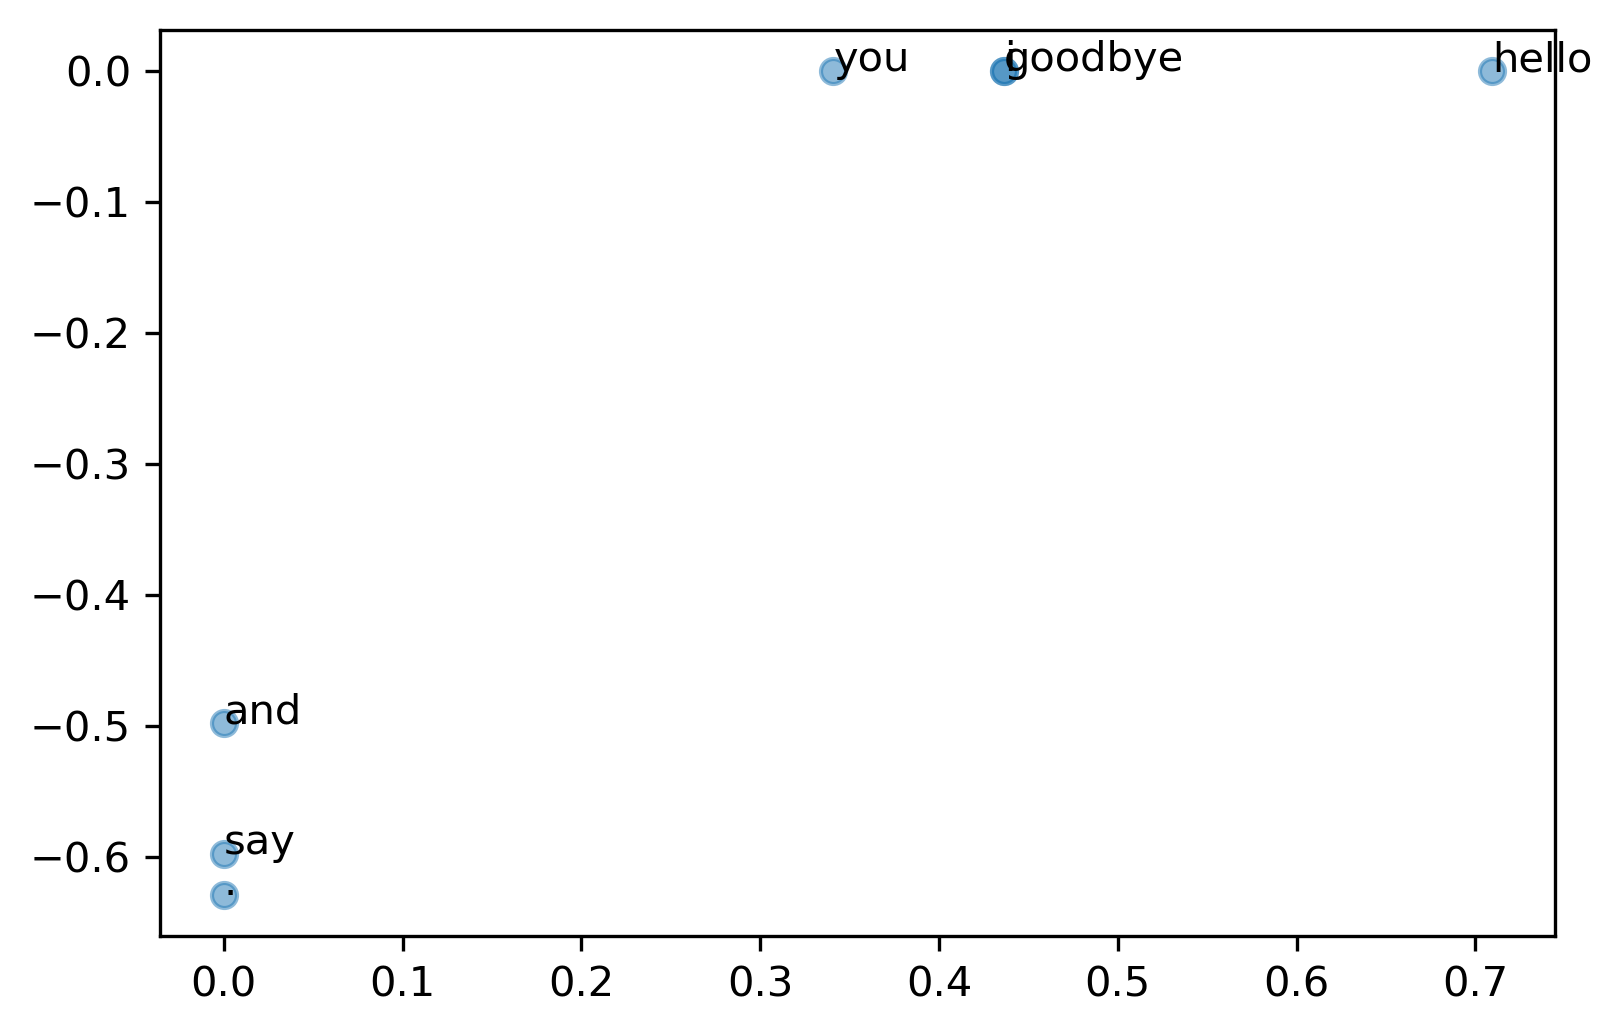

In [20]:
import matplotlib.pyplot as plt

# SVD
U, S, V = np.linalg.svd(W)

np.set_printoptions(precision=3)  # 有効桁３桁で表示
print(C[0]) # 共起行列
print(W[0]) # PPMI
print(U[0]) # SVD

# plot
plt.figure(dpi=300)
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))
plt.scatter(U[:,0], U[:,1], alpha=0.5) # 2次元でプロット
plt.show()

元は疎ベクトルであった`W[0]`が、SVDにより密ベクトル`U[0]`に変換された。なお「i」と「goodbye」は重なっている。<br>
「you」と「i」、「hello」と「goodbye」は近い位置にあるが、コーパスが小さいため、完全なものではない。

## PTBデータセット

PTBコーパスは、大きなテキストデータに前処理を施したもの。

In [21]:
from dataset import ptb


corpus, word_to_id, id_to_word = ptb.load_data('train')

print('corpus size:', len(corpus))
print('corpus[:30]:', corpus[:30])
print()
print('id_to_word[0]:', id_to_word[0])
print('id_to_word[1]:', id_to_word[1])
print('id_to_word[2]:', id_to_word[2])
print()
print("word_to_id['car']:", word_to_id['car'])
print("word_to_id['happy']:", word_to_id['happy'])
print("word_to_id['lexus']:", word_to_id['lexus'])


corpus size: 929589
corpus[:30]: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

id_to_word[0]: aer
id_to_word[1]: banknote
id_to_word[2]: berlitz

word_to_id['car']: 3856
word_to_id['happy']: 4428
word_to_id['lexus']: 7426


以下に関して、行列サイズを$N$とすると、SVDの計算は$O(N^3)$のオーダーになり、現実にこの計算は手に負えない。<br>
乱数を使った**Truncated SVD**は、特異値の小さなものは切り捨てることで高速に処理する。

In [22]:
%%time

window_size = 2
wordvec_size = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)
print('counting  co-occurrence ...')
C = create_co_matrix(corpus, vocab_size, window_size)
print('calculating PPMI ...')
W = ppmi(C)

print('calculating SVD ...')
try:
    # truncated SVD (fast!)
    from sklearn.utils.extmath import randomized_svd
    U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5,
                             random_state=None)
except ImportError:
    # SVD (slow)
    U, S, V = np.linalg.svd(W)

word_vecs = U[:, :wordvec_size]

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)

counting  co-occurrence ...
calculating PPMI ...
calculating SVD ...

[query] you
 i: 0.6754429340362549
 we: 0.6237741112709045
 do: 0.5520687103271484
 'd: 0.5285007357597351
 someone: 0.5123152136802673

[query] year
 months: 0.6390316486358643
 quarter: 0.6356461644172668
 month: 0.6273040771484375
 next: 0.6239402890205383
 earlier: 0.6118102669715881

[query] car
 auto: 0.6388919353485107
 domestic: 0.6074377298355103
 luxury: 0.5790956616401672
 corsica: 0.5260443091392517
 vehicle: 0.48187386989593506

[query] toyota
 motor: 0.6958123445510864
 motors: 0.6670407652854919
 lexus: 0.6319730877876282
 nissan: 0.603193461894989
 honda: 0.5690886378288269
CPU times: user 7min 14s, sys: 7.24 s, total: 7min 21s
Wall time: 7min 3s


人間の感覚に近い結果になり、単語の意味をベクトルにエンコードできたことになる。

## 問題点

SVDは、$n\times n$の行列に対し、$O(N^3)$の計算コストがかかる。<br>
近似的な手法や、疎な行列の性質などの利用により、ある程度処理速度を向上させられたとしても、上のように多くの計算リソースと時間が必要。

# 推論ベースの手法

学習データを一度にまとめて処理するカウントベースの手法と異なり、推論ベースの手法では、学習データの一部を逐次的に学習するため、ニューラルネットワークにおいてデータを小分けに学習したり、複数GPUの利用による並列計算も可能であり、学習を高速化できる。<br><br>
単語をベクトルで表すと、ニューラルネットワークにおいて、さまざまなレイヤで処理ができるようになる。<br>
ニューラルネットワークで、出現する単語を推測することを目的とし、副産物として単語の分散表現を得る。<br><br>
word2veecには、**CBOWモデル**と**skip-gramモデル**の2つがある。

## CBOWモデルの仕組み

![](CBOW.png)

図のように、continuous bag-of-wordsと呼ばれるモデルは、複数の単語（コンテキスト）から一つの単語（ターゲット）を推測する。<br>
$\mathrm{W}_{\mathrm{in}}$を単語の分散表現として利用する。

$w_{t-1}$と$w_{t+1}$が与えられたときに$w_t$が起こる確率は

$$P\left( w_t| w_{t-1},w_{t+1} \right)$$

これを交差エントロピー誤差に適用して

$$L= -\log P\left( w_t| w_{t-1},w_{t+1} \right)$$

コーパス全体に拡張して（**負の対数尤度**）

$$L=-\dfrac{1}{T}\sum ^{T}_{t=1}\log P\left( w_t| w_{t-1},w_{t+1} \right) $$

### Embeddingレイヤ

以下は、全結合層による変換。

In [23]:
import numpy as np
from common.layers import MatMul

c = np.array([[1, 0, 0, 0, 0, 0, 0]])
W = np.random.randn(7, 3)
layer = MatMul(W)
h = layer.forward(c)
h

array([[-0.302, -2.39 , -0.695]])

![](image2.png)

この操作は、重みから行ベクトルを抜き出すだけであるから、行列計算をするのは非効率である。<br>
以下のように、行列から行を抜き出す処理を簡単に行うレイヤを実装する。

**順伝播処理**<br>

In [24]:
W = np.arange(21).reshape(7, 3)
idx = np.array([1, 0, 3, 0])
print(W)
print()
print(W[idx])

[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]
 [15 16 17]
 [18 19 20]]

[[ 3  4  5]
 [ 0  1  2]
 [ 9 10 11]
 [ 0  1  2]]


**逆伝播処理**

1. 重みの勾配を`dW`として取り出し、`dW`の形状を保ったまま要素を0で上書きする。
2. 前層から伝わる勾配`dout`を、`idx`で指定された行に代入する。
3. `idx`の要素が重複する場合、重複するどちらかの値が上書きされてしまうことを防ぐため、`dh`の各行の値を`dW`の対応する行に加算。

In [25]:
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0
        np.add.at(dW, self.idx, dout)
        return None

### Embedding Dotレイヤ

出力層において、すべての単語を対象に確率を求める計算を行う（多値分類）と、計算が多くなる。<br>
そのため、正解の単語には正解ラベル1を設定し、間違いの単語には正解ラベル0を与え、計算量を減らす（二値分類）。

In [26]:
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None

    def forward(self, h, idx):
        target_W = self.embed.forward(idx) # idxを呼ぶ
        out = np.sum(target_W * h, axis=1) # 内積計算

        self.cache = (h, target_W)
        return out

    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)

        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

### Negative Sampling

計算量を減らすため、間違った単語の例を少数サンプリングし、それには正解ラベルとして0を与え学習させる。<br>
その際、コーパスの単語の出現頻度を確立分布で表し、多く登場する単語をカバーする。

#### 確立分布の作成

$$P'\left( w_{i}\right) =\dfrac{P\left( w_{i}\right) ^{0.75}}{\sum ^{n}_{j}P\left( w_{i}\right) ^{0.75}}$$
$P(w_i)$は、$i$番目の単語の確率

In [27]:
p = [0.7, 0.29, 0.01]
new_p = np.power(p, 0.75)
new_p /= np.sum(new_p)
print(new_p)

[0.642 0.332 0.027]


0.75乗をすることで、確率の低い単語が少しサンプリングされやすくなる。以下で、負例のサンプリングを行うクラスを実装する。

In [28]:
from common.np import *  # import numpy as np
import collections
class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None

        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1

        vocab_size = len(counts)
        self.vocab_size = vocab_size

        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]

        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)

    def get_negative_sample(self, target):
        batch_size = target.shape[0]

        if not GPU:
            negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)

            for i in range(batch_size):
                p = self.word_p.copy()
                target_idx = target[i]
                p[target_idx] = 0
                p /= p.sum()
                negative_sample[i, :] = np.random.choice(self.vocab_size, size=self.sample_size, replace=False, p=p)
        else:
            # GPU(cupy）で計算するときは、速度を優先
            # 負例にターゲットが含まれるケースがある
            negative_sample = np.random.choice(self.vocab_size, size=(batch_size, self.sample_size),
                                               replace=True, p=self.word_p)

        return negative_sample

以下は、それぞれのデータに対し、負例として2つのサンプリングを行う例。

In [29]:
corpus = np.array([0, 1, 2, 3, 4, 1, 2, 3])
power = 0.75
sample_size = 2

sampler = UnigramSampler(corpus, power, sample_size)
target = np.array([1, 3, 0])
negative_sample = sampler.get_negative_sample(target)
print(negative_sample)

[[0 2]
 [0 4]
 [2 3]]


#### 実装

In [37]:
from layers import SigmoidWithLoss

class NegativeSamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)] # 正例用レイヤを1つ、負例用をsample_size個
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]

        self.params, self.grads = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, h, target): # 中間層のニューロンh、正例ターゲットtarget
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target) # 負例のサンプリング

        # 正例のフォワード
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)

        # 負例のフォワード
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)

        return loss

    def backward(self, dout=1):
        dh = 0
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)

        return dh

## CBOWモデルの実装

### 学習データの準備

コーパス（corpus）を与えると、コンテキスト（contexts）とターゲット（target）を返し、one-hot表現に変換する処理を実装する。

In [38]:
def create_contexts_target(corpus, window_size=1):
    
    target = corpus[window_size:-window_size]
    contexts = []

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)

    return np.array(contexts), np.array(target)

In [39]:
def convert_one_hot(corpus, vocab_size):
  
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

In [40]:
contexts, target = create_contexts_target(corpus, window_size=1)
vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

### CBOWクラスの実装

In [41]:
class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size

        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')

        # レイヤの生成
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)  # Embeddingレイヤを使用
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)

        # すべての重みと勾配をリストにまとめる
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss

    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

### 学習の実装

| epoch 1 |  iter 1 / 9295 | time 0[s] | loss 4.16
| epoch 1 |  iter 2001 / 9295 | time 69[s] | loss 2.72
| epoch 1 |  iter 4001 / 9295 | time 138[s] | loss 2.45
| epoch 1 |  iter 6001 / 9295 | time 206[s] | loss 2.36
| epoch 1 |  iter 8001 / 9295 | time 274[s] | loss 2.28
| epoch 2 |  iter 1 / 9295 | time 318[s] | loss 2.23
| epoch 2 |  iter 2001 / 9295 | time 386[s] | loss 2.16
| epoch 2 |  iter 4001 / 9295 | time 454[s] | loss 2.12
| epoch 2 |  iter 6001 / 9295 | time 522[s] | loss 2.08
| epoch 2 |  iter 8001 / 9295 | time 590[s] | loss 2.05
| epoch 3 |  iter 1 / 9295 | time 634[s] | loss 2.02
| epoch 3 |  iter 2001 / 9295 | time 703[s] | loss 1.95
| epoch 3 |  iter 4001 / 9295 | time 771[s] | loss 1.94
| epoch 3 |  iter 6001 / 9295 | time 839[s] | loss 1.92
| epoch 3 |  iter 8001 / 9295 | time 907[s] | loss 1.91
| epoch 4 |  iter 1 / 9295 | time 951[s] | loss 1.90
| epoch 4 |  iter 2001 / 9295 | time 1019[s] | loss 1.82
| epoch 4 |  iter 4001 / 9295 | time 1087[s] | loss 1.82
| epo

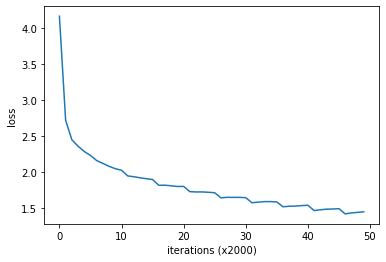

In [42]:
import sys
sys.path.append('..')
from common import config
from common.np import *
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import to_cpu
from dataset import ptb


# ハイパーパラメータの設定
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)

# モデルなどの生成
model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 学習開始
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 後ほど利用できるように、必要なデータを保存
word_vecs = model.word_vecs

params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

学習ごとに損失が小さくなっている。

### モデルの評価

In [45]:
pkl_file = 'cbow_params.pkl'

with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']
    
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 we: 0.7119140625
 i: 0.697265625
 your: 0.6240234375
 anybody: 0.61767578125
 they: 0.580078125

[query] year
 month: 0.84130859375
 week: 0.76513671875
 summer: 0.7548828125
 spring: 0.73974609375
 decade: 0.68994140625

[query] car
 window: 0.66015625
 auto: 0.63623046875
 luxury: 0.6337890625
 cars: 0.5986328125
 truck: 0.59619140625

[query] toyota
 ford: 0.61474609375
 honda: 0.61328125
 nissan: 0.60986328125
 seita: 0.60888671875
 engines: 0.60009765625


ベクトルの類似度が高い単語が、人間の感覚とほぼ合っている。

In [46]:
def normalize(x):
    if x.ndim == 2:
        s = np.sqrt((x * x).sum(1))
        x /= s.reshape((s.shape[0], 1))
    elif x.ndim == 1:
        s = np.sqrt((x * x).sum())
        x /= s
    return x

In [47]:
def analogy(a, b, c, word_to_id, id_to_word, word_matrix, top=5, answer=None):
    for word in (a, b, c):
        if word not in word_to_id:
            print('%s is not found' % word)
            return

    print('\n[analogy] ' + a + ':' + b + ' = ' + c + ':?')
    a_vec, b_vec, c_vec = word_matrix[word_to_id[a]], word_matrix[word_to_id[b]], word_matrix[word_to_id[c]]
    query_vec = b_vec - a_vec + c_vec
    query_vec = normalize(query_vec)

    similarity = np.dot(word_matrix, query_vec)

    if answer is not None:
        print("==>" + answer + ":" + str(np.dot(word_matrix[word_to_id[answer]], query_vec)))

    count = 0
    for i in (-1 * similarity).argsort():
        if np.isnan(similarity[i]):
            continue
        if id_to_word[i] in (a, b, c):
            continue
        print(' {0}: {1}'.format(id_to_word[i], similarity[i]))

        count += 1
        if count >= top:
            return

In [48]:
analogy('king', 'man', 'queen',  word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'go',  word_to_id, id_to_word, word_vecs)
analogy('car', 'cars', 'child',  word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad',  word_to_id, id_to_word, word_vecs)


[analogy] king:man = queen:?
 a.m: 6.0859375
 woman: 5.4609375
 gene: 4.703125
 daffynition: 4.5625
 carolinas: 4.55859375

[analogy] take:took = go:?
 're: 5.1953125
 eurodollars: 4.78515625
 came: 4.7578125
 went: 4.5703125
 were: 4.12890625

[analogy] car:cars = child:?
 a.m: 7.47265625
 rape: 6.05078125
 daffynition: 5.48828125
 children: 5.44140625
 incest: 5.40234375

[analogy] good:better = bad:?
 rather: 6.06640625
 more: 5.69921875
 less: 5.4609375
 greater: 4.29296875
 fewer: 4.078125


ベクトルの加減算で、類推問題（アナロジー問題）を完璧ではないが、解くことができ、単語の性質を単語の分散表現にエンコードできたといえる。<br>
この類推問題の結果を、人間の感覚に基づいて採点し、単語の分散表現の精度とするのが一般的。

## skip-gramモデルの仕組み

![](skip-gram.png)

skip-gramモデルはCBOWとは反対に、1つのターゲットから周りのコンテキストを推測する。<br>
一般に、単語の分散表現の精度については、CBOWモデルよりもskip-gramモデルの方が優れている。一方学習速度はCBOWの方が高速。

$w_t$が与えられたときに$w_{t-1}$と$w_{t+1}$が同時に起こる確率は

$$P\left( w_{t-1},w_{t+1}| w_t\right)=P\left( w_{t-1}| w_t\right)P\left( w_{t+1}| w_t\right)$$

これを交差エントロピー誤差に適用して

$$\begin{align}
L
&= -\log P\left( w_{t-1},w_{t+1}| w_t\right) \\\\
&= -\log P\left( w_{t-1}| w_{t}\right) P\left( w_{t+1}| w_{t}\right) \\\\
&= -\left\{ \log P\left( w_{t-1}| w_{t}\right) +\log P\left( w_{t+1}| w_{t}\right) \right\} 
\end{align}$$

コーパス全体に拡張して

$$L=-\dfrac{1}{T}\sum ^{T}_{t=1}\left\{ \log P\left( w_{t-1}| w_{t}\right) +\log P\left( w_{t+1}| w_{t}\right) \right\} $$



skip-gramモデルではコンテキストの数だけ推測するため、損失関数は各コンテキストで求めた損失の総和を計算する。

## skip-gramモデルの実装

基本的にCBOWモデルと同じ処理フロー。

In [49]:
class SkipGram:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size
        rn = np.random.randn

        # 重みの初期化
        W_in = 0.01 * rn(V, H).astype('f')
        W_out = 0.01 * rn(V, H).astype('f')

        # レイヤの生成
        self.in_layer = Embedding(W_in)
        self.loss_layers = []
        for i in range(2 * window_size):
            layer = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)
            self.loss_layers.append(layer)

        # すべての重みと勾配をリストにまとめる
        layers = [self.in_layer] + self.loss_layers
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = self.in_layer.forward(target)

        loss = 0
        for i, layer in enumerate(self.loss_layers):
            loss += layer.forward(h, contexts[:, i])
        return loss

    def backward(self, dout=1):
        dh = 0
        for i, layer in enumerate(self.loss_layers):
            dh += layer.backward(dout)
        self.in_layer.backward(dh)
        return None

| epoch 1 |  iter 1 / 9295 | time 0[s] | loss 41.59
| epoch 1 |  iter 2001 / 9295 | time 422[s] | loss 28.09
| epoch 1 |  iter 4001 / 9295 | time 845[s] | loss 24.98
| epoch 1 |  iter 6001 / 9295 | time 1271[s] | loss 24.51
| epoch 1 |  iter 8001 / 9295 | time 1693[s] | loss 24.29
| epoch 2 |  iter 1 / 9295 | time 1967[s] | loss 24.17
| epoch 2 |  iter 2001 / 9295 | time 2395[s] | loss 23.95
| epoch 2 |  iter 4001 / 9295 | time 2821[s] | loss 23.90
| epoch 2 |  iter 6001 / 9295 | time 3244[s] | loss 23.84
| epoch 2 |  iter 8001 / 9295 | time 3675[s] | loss 23.77
| epoch 3 |  iter 1 / 9295 | time 3963[s] | loss 23.73
| epoch 3 |  iter 2001 / 9295 | time 4387[s] | loss 23.50
| epoch 3 |  iter 4001 / 9295 | time 4816[s] | loss 23.49
| epoch 3 |  iter 6001 / 9295 | time 5246[s] | loss 23.49
| epoch 3 |  iter 8001 / 9295 | time 5675[s] | loss 23.47
| epoch 4 |  iter 1 / 9295 | time 5949[s] | loss 23.45
| epoch 4 |  iter 2001 / 9295 | time 6373[s] | loss 23.18
| epoch 4 |  iter 4001 / 9295 |

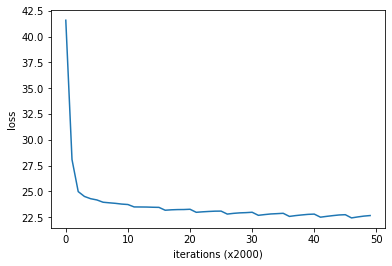

In [50]:
import sys
sys.path.append('..')
from common import config
from common.np import *
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import to_cpu
from dataset import ptb


# ハイパーパラメータの設定
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)

# モデルなどの生成
model = SkipGram(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# 学習開始
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

# 後ほど利用できるように、必要なデータを保存
word_vecs = model.word_vecs

params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'skipgram_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

In [59]:
pkl_file = 'skipgram_params.pkl'

with open(pkl_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']
    
querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)


[query] you
 i: 0.6748046875
 your: 0.66162109375
 somebody: 0.6337890625
 yourself: 0.625
 we: 0.62158203125

[query] year
 earlier: 0.61474609375
 month: 0.5830078125
 week: 0.57958984375
 quarter: 0.5205078125
 period: 0.5048828125

[query] car
 cars: 0.66357421875
 truck: 0.55712890625
 luxury: 0.55078125
 mazda: 0.5302734375
 motor: 0.5224609375

[query] toyota
 motor: 0.66552734375
 honda: 0.65771484375
 lexus: 0.65185546875
 infiniti: 0.64794921875
 chevrolet: 0.640625


In [64]:
analogy('king', 'man', 'queen',  word_to_id, id_to_word, word_vecs)
analogy('take', 'took', 'eat',  word_to_id, id_to_word, word_vecs)
analogy('book', 'books', 'car',  word_to_id, id_to_word, word_vecs)
analogy('good', 'better', 'bad',  word_to_id, id_to_word, word_vecs)


[analogy] king:man = queen:?
 mystery: 1.7685546875
 neglected: 1.7021484375
 murdered: 1.6962890625
 discarded: 1.6689453125
 lady: 1.638671875

[analogy] take:took = eat:?
 yards: 1.8837890625
 clothes: 1.8759765625
 wore: 1.87109375
 sang: 1.703125
 tall: 1.673828125

[analogy] book:books = car:?
 chevrolet: 1.78125
 mortgage: 1.73828125
 beretta: 1.732421875
 rental: 1.5703125
 honda: 1.5693359375

[analogy] good:better = bad:?
 burned: 1.6591796875
 worse: 1.599609375
 comparable: 1.5927734375
 impressive: 1.48046875
 diversification: 1.478515625


得られた単語の分散表現はあまり正確でないと推測できる。